# Face Mask Detection Using YOLOv4
*Francisco de Abreu e Lima - 22 June, 2021*

In this notebook we will fine-tune a pre-trained YOLOv4 model to identify bare faces and mask-wearing faces. To this end we must

- Clone the DarkNet GitHub repository, compile
- Download dataset, test media (images and videos) and the YOLOv4 convolutional backbone
- Partition train and test data, edit existing `class.names`, `.cfg` and `.data` files
- Train network, run inference on test media and display prediction example

Instructions can be found [here](https://github.com/AlexeyAB/darknet#how-to-train-to-detect-your-custom-objects). The key change I have made was to reduce `max_batches` to 2000 instead of 4000 - and `steps` accordingly - as the latter value lead to systematic disconnects from the GPU-powered runtime.


## 1. Download and compile DarkNet

Firstly we need to clone the DarkNet GitHub repository, then compile `darknet` with the `OPENCV`, `GPU` and `CUDA` options, as shown below.

In [1]:
# Clone Darknet GitHub repo
!git clone https://github.com/AlexeyAB/darknet.git

# cd and compile w/ OpenCV and GPU options enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile

print('Building... This can take two minutes')
!make &> build_log.txt

Cloning into 'darknet'...
remote: Enumerating objects: 15132, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 15132 (delta 26), reused 41 (delta 19), pack-reused 15073
Receiving objects: 100% (15132/15132), 13.47 MiB | 20.64 MiB/s, done.
Resolving deltas: 100% (10271/10271), done.
/content/darknet
Building... This can take two minutes


## 2. Download YOLOv4 conv backbone, dataset and test media

To bring our model to its fullest potential, we will leverage transfer learning by borrowing the convolutional backbone trained using ImageNet. We will download the corresponding structure and weights, as well as the provided annotated mask / no-mask dataset - output format already conforms to YOLO - and test images and videos to predict on, after training.

In [2]:
%%bash
# Download conv backbone from YOLOv4, dataset and test imgs/vids (silent mode)
wget "https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137" -q
wget "https://www.dropbox.com/s/uq0x32w70c390fb/mask_no-mask_dataset.zip?dl=1" -q -O dataset.zip
unzip -q dataset.zip -d data/mask && rm dataset.zip
wget "https://www.dropbox.com/s/fxei8rit9v2n83s/test-image1.jpg?dl=1" -q -O test-image1.jpg
wget "https://www.dropbox.com/s/ia1fijzr69ytpp1/test-image2.jpg?dl=1" -q -O test-image2.jpg
wget "https://www.dropbox.com/s/g905k4r1git5kbx/test-image3.jpg?dl=1" -q -O test-image3.jpg
wget "https://www.dropbox.com/s/90ggmiur7b8g35m/test-image4.jpg?dl=1" -q -O test-image4.jpg
wget "https://www.dropbox.com/s/pds0w3z5y7w89oz/test-video1.mp4?dl=1" -q -O test-video1.mp4
wget "https://www.dropbox.com/s/sqwu0ktdtlxtdsd/test-video2.mp4?dl=1" -q -O test-video2.mp4

## 3. Partition train and test data

Here we will use code from the course to partition the dataset into train and test sets. Note that the partition is not seeded, and each time it provides different splits.

In [3]:
# Prepare dataset
import random
import os
import subprocess
import sys

image_dir = "./data/mask"
f_val = open("data/mask_test.txt", 'w')
f_train = open("data/mask_train.txt", 'w')

path, dirs, files = next(os.walk(image_dir))
data_size = len(files)

ind = 0
data_test_size = int(0.2 * data_size)
test_array = random.sample(range(data_size), k=data_test_size)

for f in os.listdir(image_dir):
    if(f.split(".")[-1] == "jpg"):
        ind += 1
        
        if ind in test_array:
            f_val.write(image_dir+'/'+f+'\n')
        else:
            f_train.write(image_dir+'/'+f+'\n')

f_train.close()
f_val.close()

## 4. Set up train and test configuration

Next we need to modify `yolov4-custom.cfg` to accommodate the two classes, `Face mask` and `Bare face`. Then, we make the necessary changes to `cfg/yolov3.cfg` to fine-tune our model. We leave momentum, decay and policy with the default values, *i.e.* 0.9, 0.0005, and `steps`, respectively. Learning rate, however, will be raised to 0.01. Likewise, we will leave the augmentation defaults. Finally, unlike YOLOv3 we need to decrease the resizing target width and height in order not to exceed the available RAM.


In [4]:
%%bash
# Setup mask.names
echo "Face mask" > data/mask.names
echo "Bare face" >> data/mask.names

# Setup mask.data
echo "classes = 2" > data/mask.data
echo "train = data/mask_train.txt" >> data/mask.data
echo "valid = data/mask_test.txt" >> data/mask.data
echo "names = data/mask.names" >> data/mask.data
echo "backup = backup/" >> data/mask.data

# Modify config file (train)
cp cfg/yolov4-custom.cfg yolo-obj.cfg
sed -i 's/filters=255/filters=21/' yolo-obj.cfg
sed -i 's/classes=80/classes=2/' yolo-obj.cfg
sed -i 's/max_batches =.*/max_batches = 2000/' yolo-obj.cfg
sed -i 's/steps=.*$/steps=1600,1800/' yolo-obj.cfg
sed -i 's/width=608/width=416/' yolo-obj.cfg
sed -i 's/height=608/height=416/' yolo-obj.cfg

Note that the configuration file is by default used for test. For this reason we will make a copy for training, `cfg/yolov4_train.cfg`.

In [5]:
%%bash
# Modify config file (test)
cp yolo-obj.cfg yolo-obj_test.cfg
sed -i 's/batch=64/batch=1/' yolo-obj_test.cfg
sed -i 's/subdivisions=16/subdivisions=1/' yolo-obj_test.cfg

## 5. Start training

We are now ready to start the training routine. This might take a while. **Note that Google Colab might restrict your GPU usage. Avoid unnecessary, long computations.**

In [6]:
# Run training routine
!./darknet detector train data/mask.data yolo-obj.cfg yolov4.conv.137 -dont_show -map 2> train_log.txt

Streaming output truncated to the last 5000 lines.
 CUDA allocate done! 
Loaded: 1.903686 seconds - performance bottleneck on CPU or Disk HDD/SSD

 (next mAP calculation at 1200 iterations) 
 Last accuracy mAP@0.5 = 73.40 %, best = 73.40 % 
 1131: 4.096855, 3.023067 avg loss, 0.001000 rate, 5.714466 seconds, 72384 images, 1.798778 hours left
Loaded: 0.000075 seconds

 (next mAP calculation at 1200 iterations) 
 Last accuracy mAP@0.5 = 73.40 %, best = 73.40 % 
 1132: 3.137295, 3.034490 avg loss, 0.001000 rate, 5.581503 seconds, 72448 images, 1.799180 hours left
Loaded: 0.000064 seconds

 (next mAP calculation at 1200 iterations) 
 Last accuracy mAP@0.5 = 73.40 %, best = 73.40 % 
 1133: 2.594569, 2.990498 avg loss, 0.001000 rate, 5.411802 seconds, 72512 images, 1.794646 hours left
Loaded: 0.000086 seconds

 (next mAP calculation at 1200 iterations) 
 Last accuracy mAP@0.5 = 73.40 %, best = 73.40 % 
 1134: 1.948944, 2.886343 avg loss, 0.001000 rate, 5.407460 seconds, 72576 images, 1.78973

The reported final mean average precision (mAP) with a IoU threshold of 50% should be ~80%.

## 6. Inference on test images and videos

To conclude, we will identify faces with and without mask on test images and videos.


In [7]:
# On images
!./darknet detector test data/mask.data yolo-obj_test.cfg backup/yolo-obj_best.weights test-image1.jpg -thresh .6 2> /dev/null
!mv predictions.jpg yolov4_test-image1_pred.jpg 

!./darknet detector test data/mask.data yolo-obj_test.cfg backup/yolo-obj_best.weights test-image2.jpg -thresh .6 2> /dev/null
!mv predictions.jpg yolov4_test-image2_pred.jpg 

!./darknet detector test data/mask.data yolo-obj_test.cfg backup/yolo-obj_best.weights test-image3.jpg -thresh .6 2> /dev/null
!mv predictions.jpg yolov4_test-image3_pred.jpg

!./darknet detector test data/mask.data yolo-obj_test.cfg backup/yolo-obj_best.weights test-image4.jpg -thresh .6 2> /dev/null
!mv predictions.jpg yolov4_test-image4_pred.jpg 

# On videos
!./darknet detector demo data/mask.data yolo-obj_test.cfg backup/yolo-obj_best.weights test-video1.mp4 -thresh .6 -out_filename yolov4_test-video1_pred.mp4 -dont_show
!./darknet detector demo data/mask.data yolo-obj_test.cfg backup/yolo-obj_best.weights test-video2.mp4 -thresh .6 -out_filename yolov4_test-video2_pred.mp4 -dont_show

Streaming output truncated to the last 5000 lines.

 cvWriteFrame 
Objects:

Bare face: 89% 
Bare face: 87% 
Face mask: 92% 

FPS:30.5 	 AVG_FPS:30.9

 cvWriteFrame 
Objects:

Bare face: 93% 
Bare face: 62% 
Face mask: 87% 

FPS:30.1 	 AVG_FPS:30.9

 cvWriteFrame 
Objects:

Bare face: 95% 
Face mask: 89% 

FPS:30.3 	 AVG_FPS:30.9

 cvWriteFrame 
Objects:

Bare face: 94% 
Bare face: 79% 
Bare face: 64% 
Face mask: 97% 
Face mask: 65% 

FPS:30.1 	 AVG_FPS:30.9

 cvWriteFrame 
Objects:

Bare face: 97% 
Bare face: 67% 
Face mask: 97% 

FPS:30.2 	 AVG_FPS:30.9

 cvWriteFrame 
Objects:

Bare face: 97% 
Bare face: 71% 
Face mask: 97% 

FPS:30.4 	 AVG_FPS:30.9

 cvWriteFrame 
Objects:

Bare face: 98% 
Bare face: 67% 
Bare face: 64% 
Bare face: 62% 
Face mask: 86% 

FPS:29.9 	 AVG_FPS:30.9

 cvWriteFrame 
Objects:

Bare face: 99% 
Bare face: 90% 
Bare face: 66% 

FPS:30.0 	 AVG_FPS:30.9

 cvWriteFrame 
Objects:

Bare face: 97% 
Bare face: 61% 

FPS:29.7 	 AVG_FPS:30.9

 cvWriteFrame 
Objects:



Finally, let us display the first test image in the list after predictions.

(-0.5, 959.5, 499.5, -0.5)

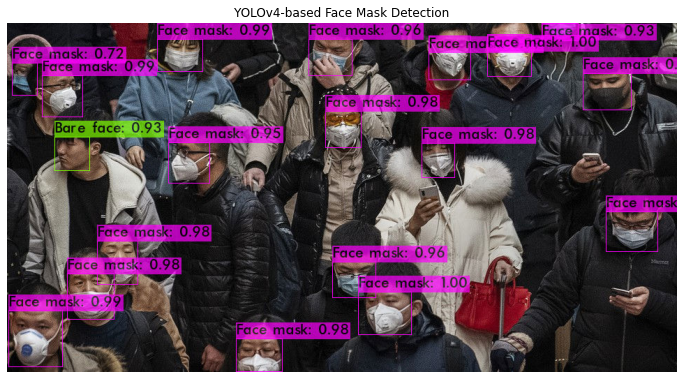

In [9]:
import cv2
import matplotlib.pyplot as plt

im = cv2.imread('yolov4_test-image3_pred.jpg')
plt.figure(figsize=(12, 12))
plt.imshow(im[...,::-1]); plt.title('YOLOv4-based Face Mask Detection'); plt.axis('off')

That is it - well done for training YOLOv4 for a custom classification task!